#### REPORT

##### Different parameters results analysis

##### Confusion Matrix

##### Feature Importance

##### Training/testing error curves

##### Sklearn classification report

In [21]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.model_selection import train_test_split

### Preprocessing the data

#### Cutting the dataset so that there is the same amount of fraud and not fraud cases

In [22]:
df = pd.read_csv('../data/card_transdata.csv')

# Get counts of fraud and non-fraud cases
fraud_count = df['fraud'].value_counts()
min_count = fraud_count.min()

# Separate fraud and non-fraud cases
fraud_df = df[df['fraud'] == 1].sample(n=min_count, random_state=42)
non_fraud_df = df[df['fraud'] == 0].sample(n=min_count, random_state=42)

# Combine the balanced datasets
df = pd.concat([fraud_df, non_fraud_df])

# Shuffle the final dataframe
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [23]:
X = df.drop(columns=["fraud"])
y = df["fraud"]

y = keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

print(X.shape)
print(y.shape)

(174806, 7)
(174806, 2)


### Plotting visualizations fo the input data

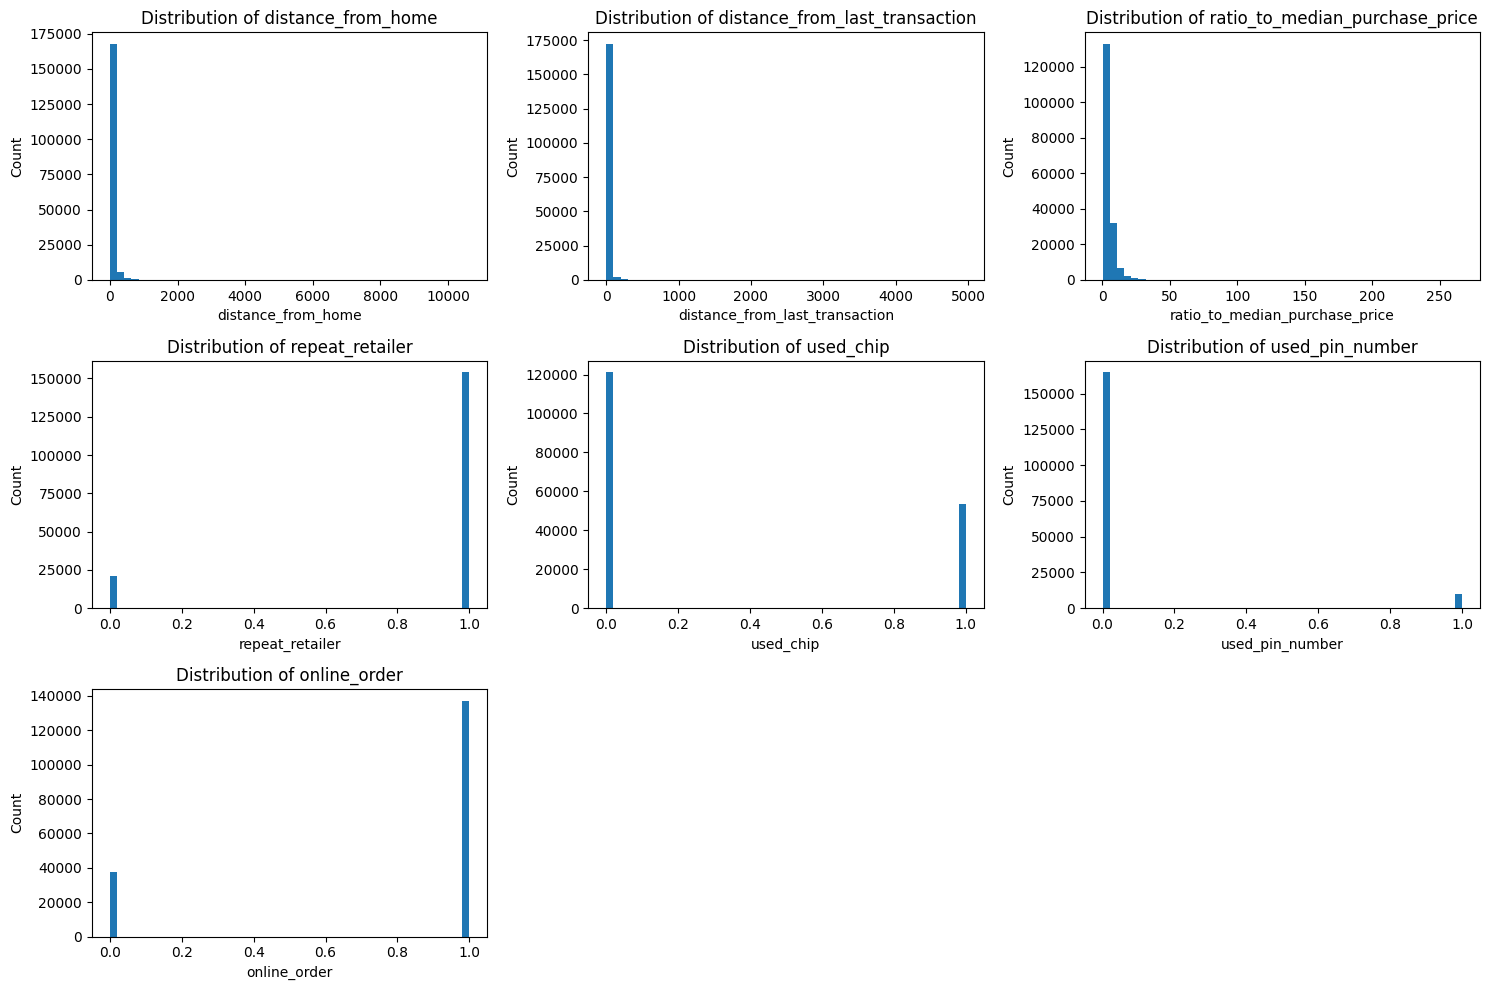

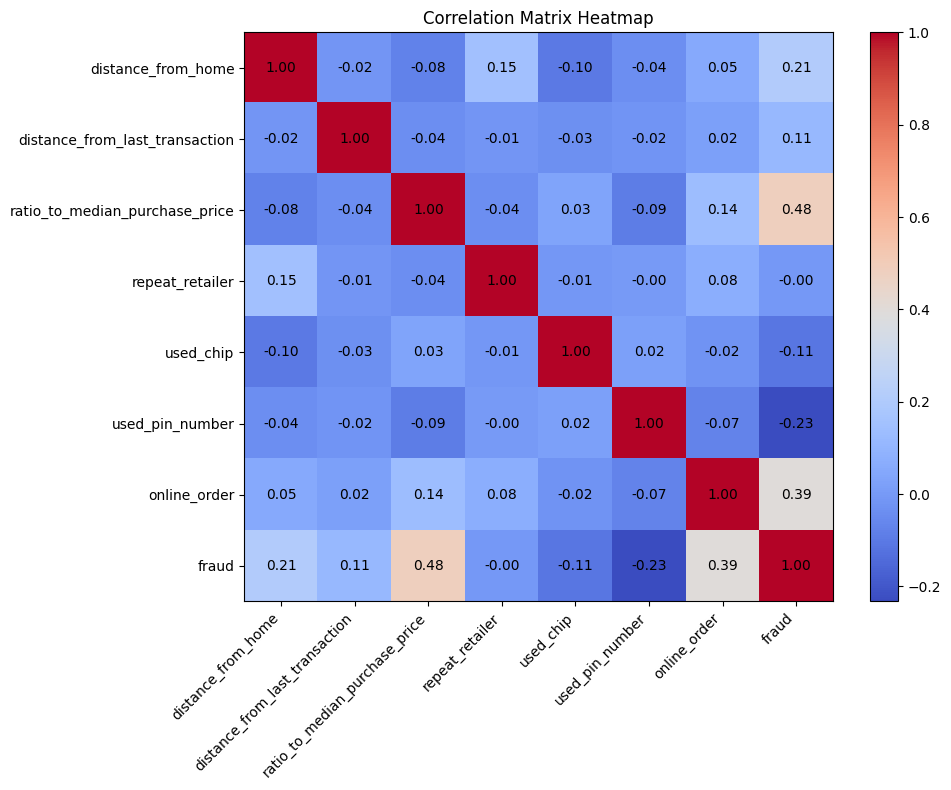

In [24]:
# features distribution
plt.figure(figsize=(15, 10))
for i, column in enumerate(X.columns, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[column], bins=50)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center')
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [25]:
# Apply PCA preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# First standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
# Keep 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Original number of features:", X_train.shape[1])
print("Number of features after PCA:", X_train_pca.shape[1])
print("Explained variance ratio:", sum(pca.explained_variance_ratio_))

# Update X_train and X_test with PCA transformed data
X_train = X_train_pca
X_test = X_test_pca

Original number of features: 7
Number of features after PCA: 7
Explained variance ratio: 1.0


### Creating the model

c:\Users\rrang\Desktop\codes\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642 (2.51 KB)

 Trainable params: 642 (2.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 3s 870us/step - accuracy: 0.9385 - loss: 0.0582 - val_accuracy: 0.9777 - val_loss: 0.0204
Epoch 2/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step - accuracy: 0.9785 - loss: 0.0189 - val_accuracy: 0.9852 - val_loss: 0.0140
Epoch 3/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 2s 822us/step - accuracy: 0.9844 - loss: 0.0140 - val_accuracy: 0.9868 - val_loss: 0.0115
Epoch 4/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 2s 833us/step - accuracy: 0.9875 - loss: 0.0112 - val_accuracy: 0.9899 - val_loss: 0.0092
Epoch 5/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 2s 819us/step - accuracy: 0.9895 - loss: 0.0092 - val_accuracy: 0.9924 - val_loss: 0.0081
Epoch 6/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step - accuracy: 0.9899 - loss: 0.0085 - val_accuracy: 0.9911 - val_loss: 0.0073
Epoch 7/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 2s 803us/step - accuracy: 0.9915 - loss: 0.0074 - val_accuracy: 0.9915 - val_loss: 0.0067
Epoch 8/50
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 2s 855us/step - accuracy: 0.9918 -

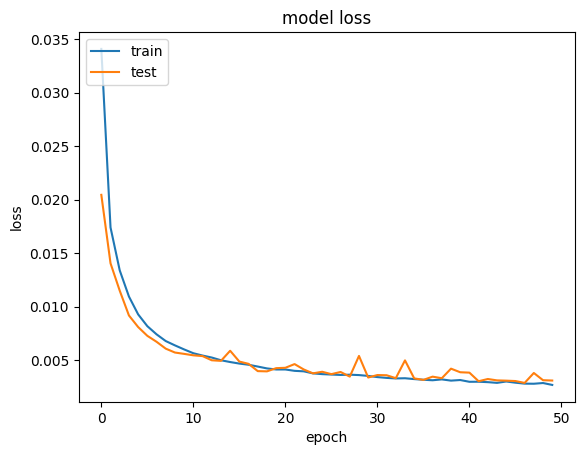

In [26]:
model = Sequential()

model.add(Dense(64, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(y.shape[1],activation='softmax'))
opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, verbose=1, mode='auto', restore_best_weights=True)
model.summary()
history = model.fit(X_train, y_train, validation_split=0.33, verbose=1, epochs=50)

pred = model.predict(X_test)

pred = np.argmax(pred,axis=1)
y_compare = np.argmax(y_test,axis=1)

# Plot training loss curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [27]:
score = metrics.accuracy_score(y_compare, pred)
print("Accuracy score: {:.2f}".format(score))

Accuracy score: 1.00


### Plotting the confusion matrix of the result

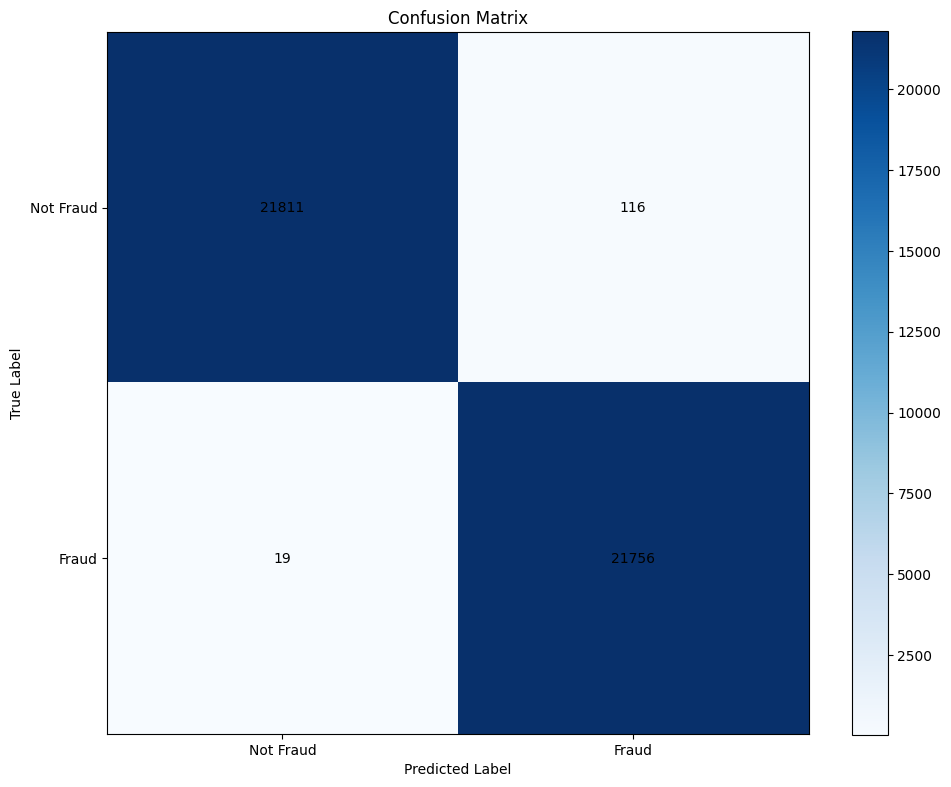

In [28]:
labels = ['Not Fraud', 'Fraud']

plt.figure(figsize=(10, 8))
confusion_mtx = metrics.confusion_matrix(y_compare, pred)
plt.imshow(confusion_mtx, interpolation='nearest', cmap='Blues')
plt.colorbar()

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j, i, str(confusion_mtx[i, j]),
                ha='center', va='center')

plt.xticks([0, 1], labels)
plt.yticks([0, 1], labels)

plt.tight_layout()
plt.show()